In [1]:
# kernel : R_edgeR
library(dplyr)
library(Seurat)
library(edgeR)
library(ggplot2)
library(tidyr)
library(ggpubr)  # For p-value annotation



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘Seurat’ was built under R version 4.4.1”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.1”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.4.1”
‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: limma

Warning message:
“package ‘ggpubr’ was built under R version 4.4.1”


# HN paper

In [1]:
breast<-readRDS("/scratch/project/stseq/Prakrithi/lnc_revision/xenium/mel/clean-data/xenium_spatial_breast_LT.rds")
GBM<-readRDS("/scratch/project/stseq/Prakrithi/lnc_revision/xenium/mel/clean-data/xenium_spatial_GBM_LT.rds")
Melanoma<-readRDS("/QRISdata/Q4386/Xenium_20250319__042556__20250319_lncRNA_IO_Cancer/output-XETG00114__0016985__Melanoma__20250319__042625/Mel_LT.rds")
HN<-readRDS("/scratch/project/stseq/Prakrithi/lnc_revision/xenium/mel/clean-data/xenium_spatial_HN_LT.rds")
CRC<-readRDS("/scratch/project/stseq/Prakrithi/lnc_revision/xenium/mel/clean-data/xenium_spatial_CRC_LT.rds")


In [4]:
names(HN@meta.data)

[1] "orig.ident"                    "nCount_Xenium"                
 [3] "nFeature_Xenium"               "nCount_ControlCodeword"       
 [5] "nFeature_ControlCodeword"      "nCount_ControlProbe"          
 [7] "nFeature_ControlProbe"         "nCount_SCT"                   
 [9] "nFeature_SCT"                  "SCT_snn_res.1"                
[11] "seurat_clusters"               "predicted.id"                 
[13] "prediction.score.CAFs"         "prediction.score.B.cells"     
[15] "prediction.score.Epithelial"   "prediction.score.TAMs"        
[17] "prediction.score.Endothelial"  "prediction.score.T.cells"     
[19] "prediction.score.Myofib"       "prediction.score.Salivary"    
[21] "prediction.score.NK"           "prediction.score.plasma.cells"
[23] "prediction.score.pDC"          "prediction.score.mature.DC"   
[25] "prediction.score.Mast.cells"   "prediction.score.max"

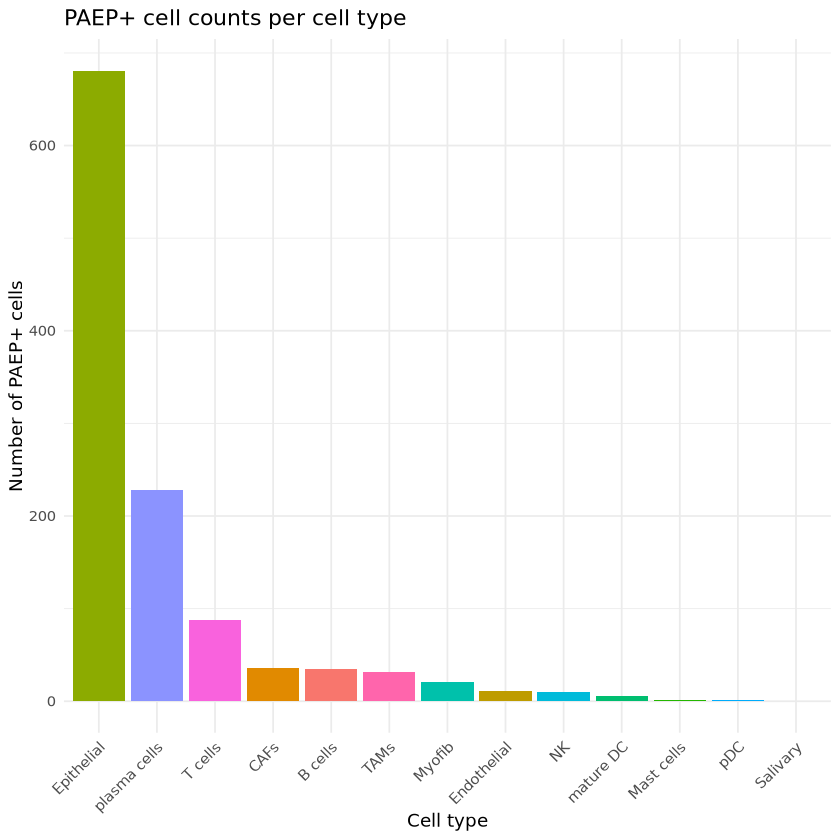

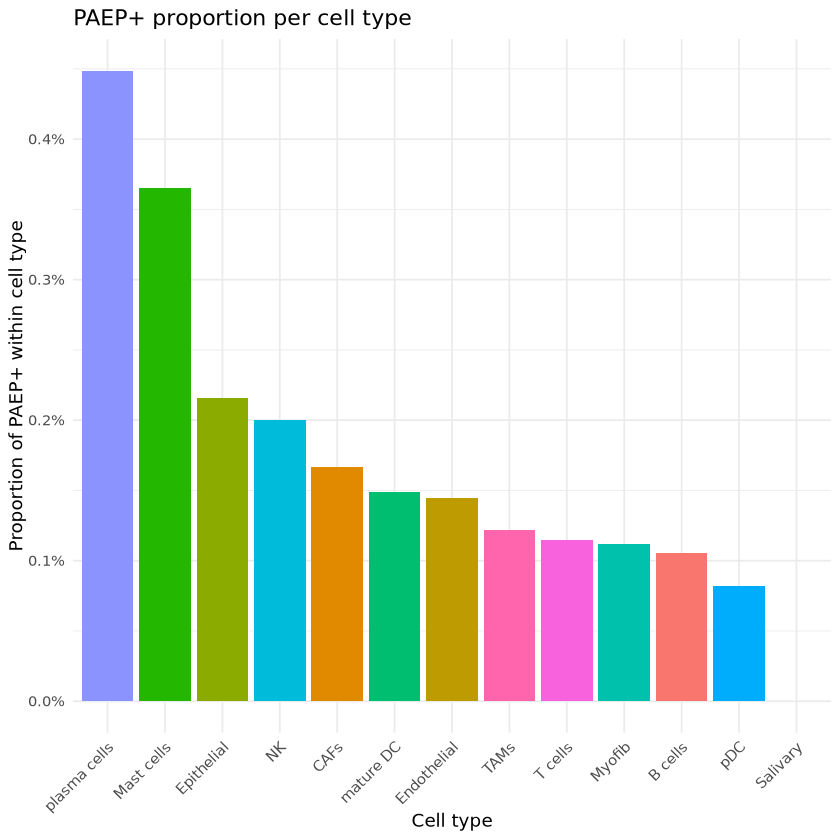

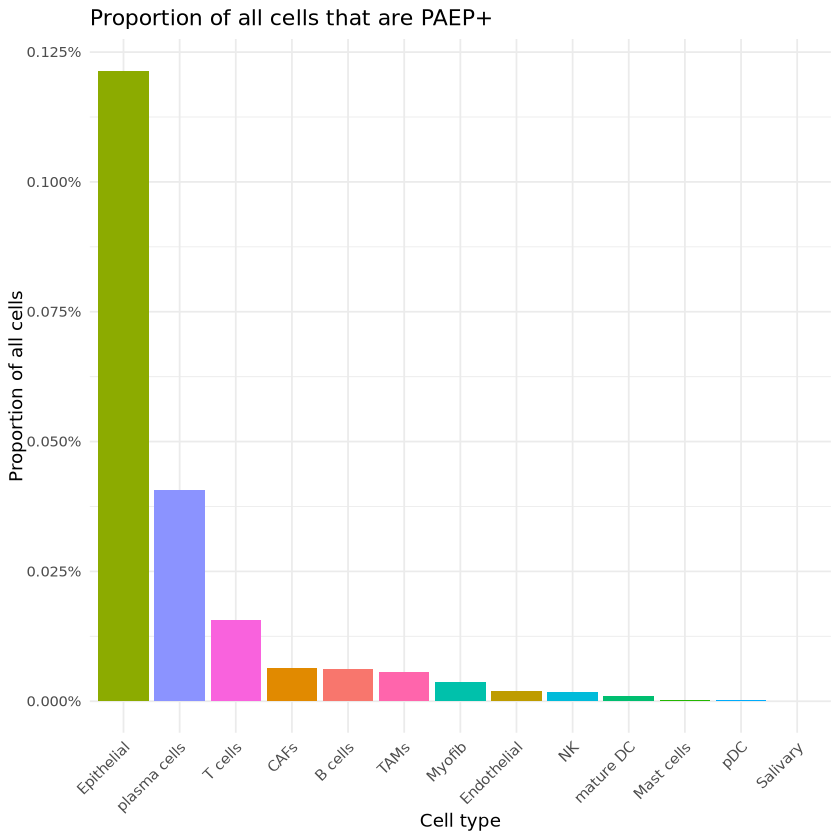

In [30]:
library(Seurat)
library(dplyr)
library(ggplot2)

# Get PAEP expression
paep_expr <- FetchData(HN, vars = "PAEP")[,1]

# Combine with metadata
df <- HN@meta.data %>%
  mutate(PAEP = paep_expr,
         Expressing = PAEP > 0)

# Count, within-type proportion, and global proportion
total_cells_all <- nrow(df)

cell_counts <- df %>%
  group_by(predicted.id) %>%
  summarise(
    total_cells = n(),
    expressing_cells = sum(Expressing),
    .groups = "drop"
  ) %>%
  mutate(
    prop_within_type = expressing_cells / total_cells,      # within each cell type
    prop_of_all_cells = expressing_cells / total_cells_all  # of all cells
  ) %>%
  arrange(desc(expressing_cells))

# --- Plot 1: Counts ---
ggplot(cell_counts, aes(x = reorder(predicted.id, -expressing_cells),
                        y = expressing_cells, fill = predicted.id)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(x = "Cell type",
       y = "Number of PAEP+ cells",
       title = "PAEP+ cell counts per cell type")

# --- Plot 2: Proportion within cell type ---
ggplot(cell_counts, aes(x = reorder(predicted.id, -prop_within_type),
                        y = prop_within_type, fill = predicted.id)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(x = "Cell type",
       y = "Proportion of PAEP+ within cell type",
       title = "PAEP+ proportion per cell type")

# --- Plot 3: Proportion of all cells ---
ggplot(cell_counts, aes(x = reorder(predicted.id, -prop_of_all_cells),
                        y = prop_of_all_cells, fill = predicted.id)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(x = "Cell type",
       y = "Proportion of all cells",
       title = "Proportion of all cells that are PAEP+")


In [63]:
pdf("HN_PAEP_violin.pdf", width=12, height=8)
VlnPlot(HN, "PAEP" , group.by = "predicted.id")
dev.off()

pdf 
  2

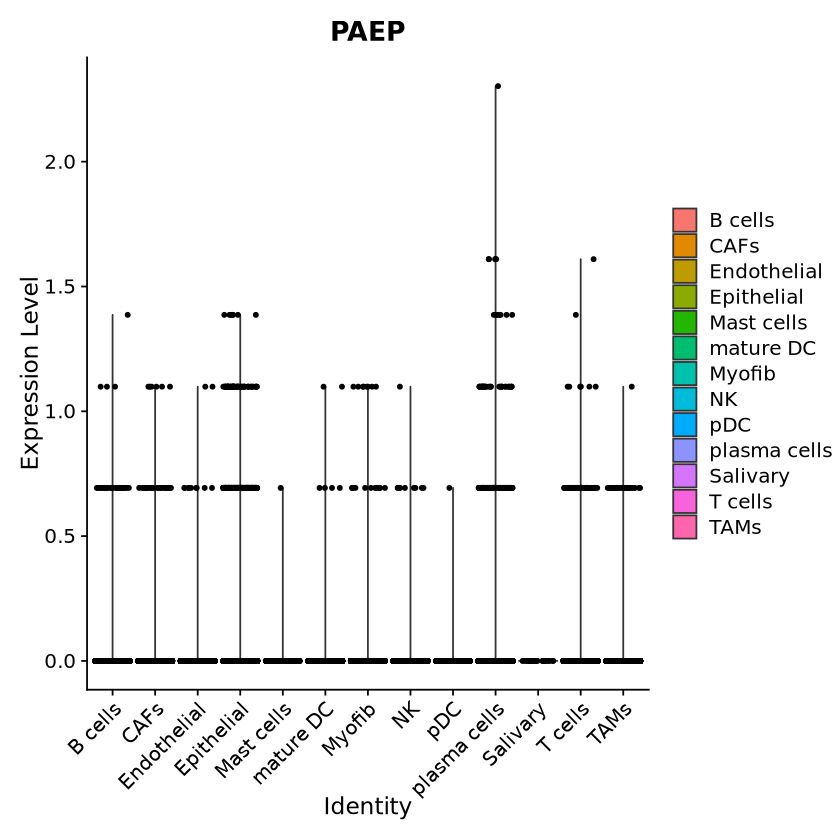

In [64]:
VlnPlot(HN, "PAEP" , group.by = "predicted.id")


Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”


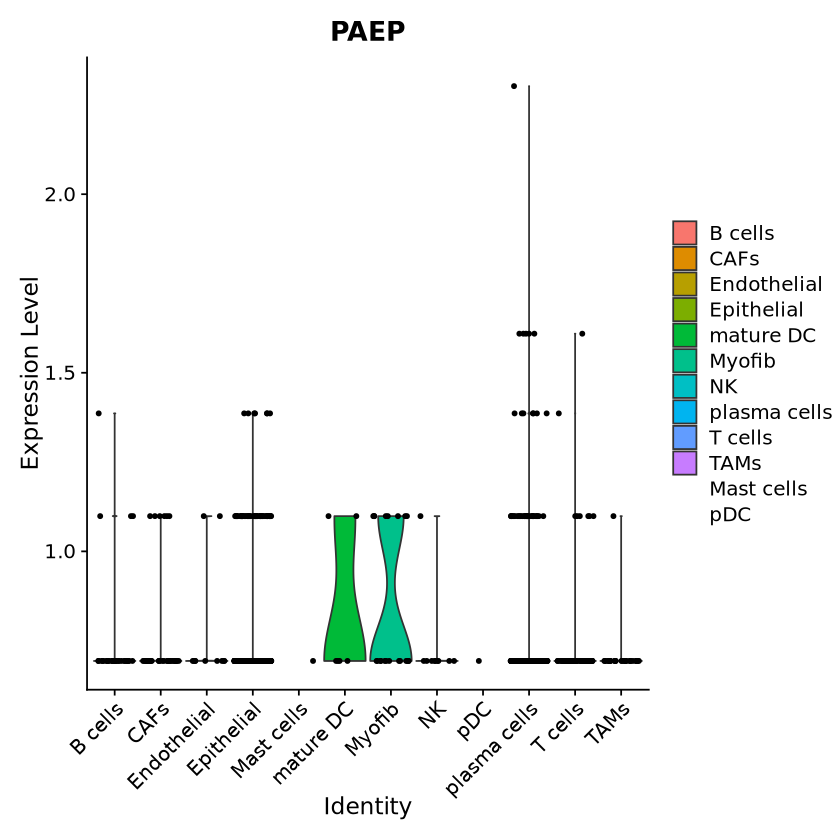

In [70]:
VlnPlot(
  subset(HN, subset = PAEP > 0),
  features = "PAEP",
  group.by = "predicted.id")


In [60]:
getwd()

[1] "/scratch/project_mnt/S0010/Prakrithi/lnc_revision/xenium"

In [65]:
pdf("HN_PAEP_cell_types_proportion.pdf", width=12, height=8)
ggplot(cell_counts, aes(x = reorder(predicted.id, -prop_of_all_cells),
                        y = prop_of_all_cells, fill = predicted.id)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(x = "Cell type",
       y = "Proportion of all cells",
       title = "Proportion of all cells that are PAEP+")
dev.off()

pdf 
  2

In [62]:
pdf("HN_PAEP_proportion_per_cell_type.pdf", width=12, height=8)
ggplot(cell_counts, aes(x = reorder(predicted.id, -prop_within_type),
                        y = prop_within_type, fill = predicted.id)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(x = "Cell type",
       y = "Proportion of PAEP+ within cell type",
       title = "PAEP+ proportion per cell type")
dev.off()

pdf 
  2

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”


# A tibble: 5 × 6
  dataset  n_cells n_paep_pos pct_paep_pos mean_expr median_expr
  <chr>      <int>      <int>        <dbl>     <dbl>       <dbl>
1 Melanoma  248057       1292        0.521   0.00567           0
2 CRC       444666       1279        0.288   0.00209           0
3 GBM       202673        575        0.284   0.00209           0
4 Breast    463299        956        0.206   0.00151           0
5 HN        560758       1150        0.205   0.00153           0
# A tibble: 67 × 6
   dataset cell_type      n_cells n_paep_pos pct_within_type pct_of_all_paep_pos
   <chr>   <chr>            <int>      <int>           <dbl>               <dbl>
 1 Breast  Cancer Epithe…  236534        627          0.265              11.9   
 2 Breast  Fibroblasts      64510        129          0.200               2.46  
 3 Breast  CD4+ T Cells     65421         94          0.144               1.79  
 4 Breast  CD8+ T Cells     23498         28          0.119               0.533 
 5 Breast  Macrophages

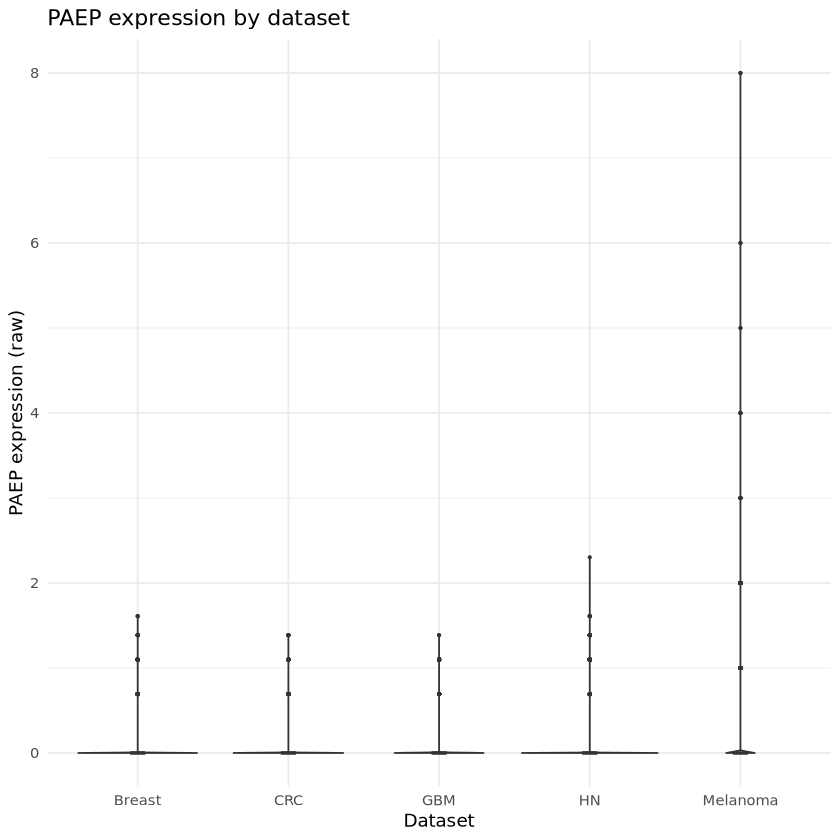

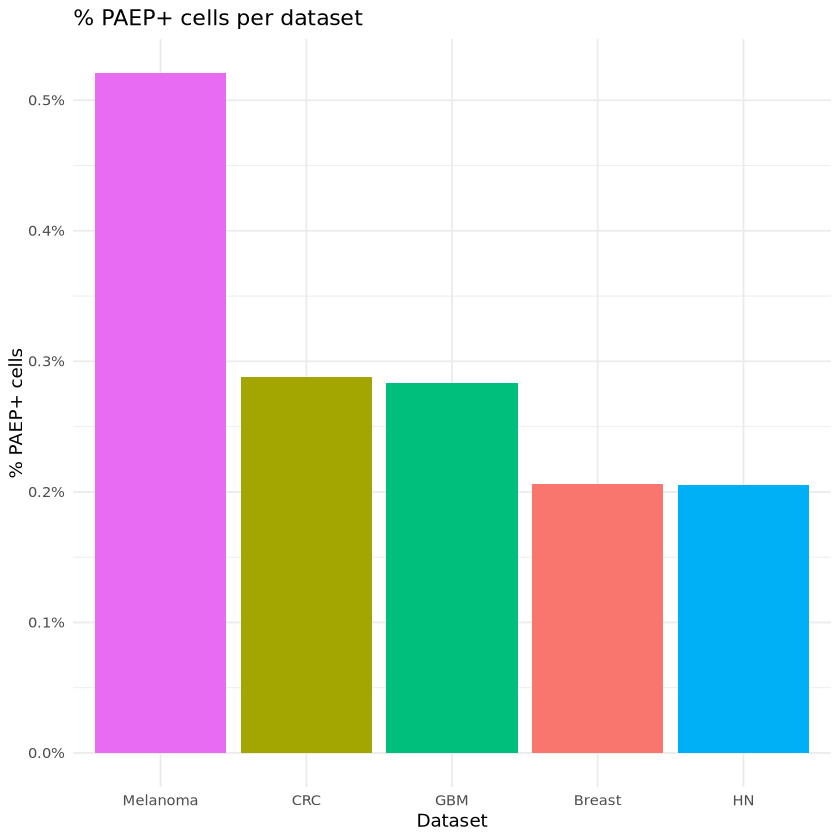

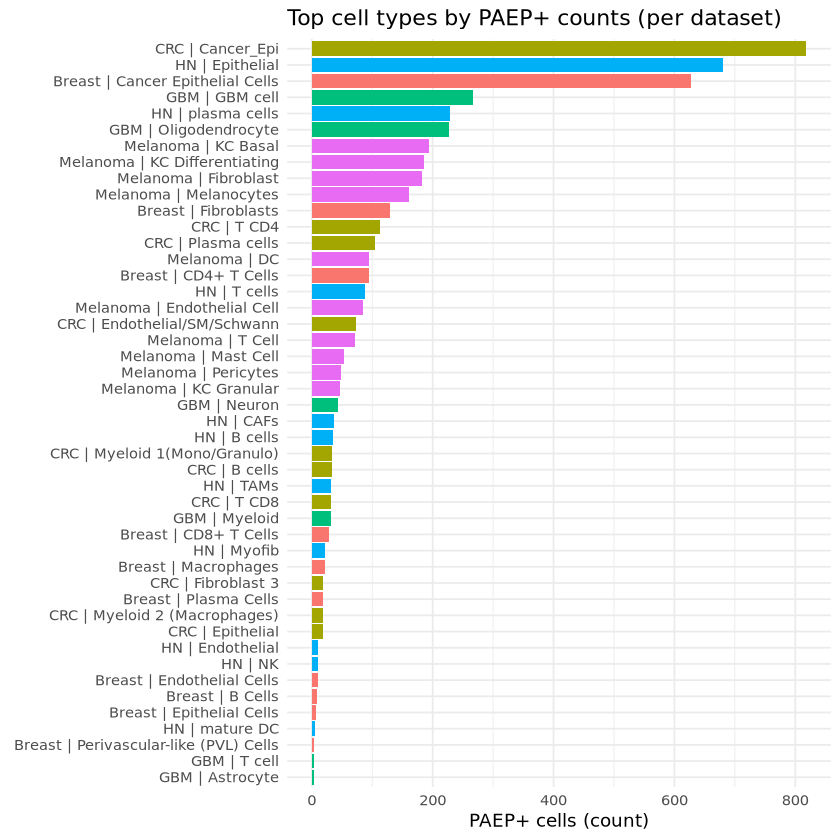

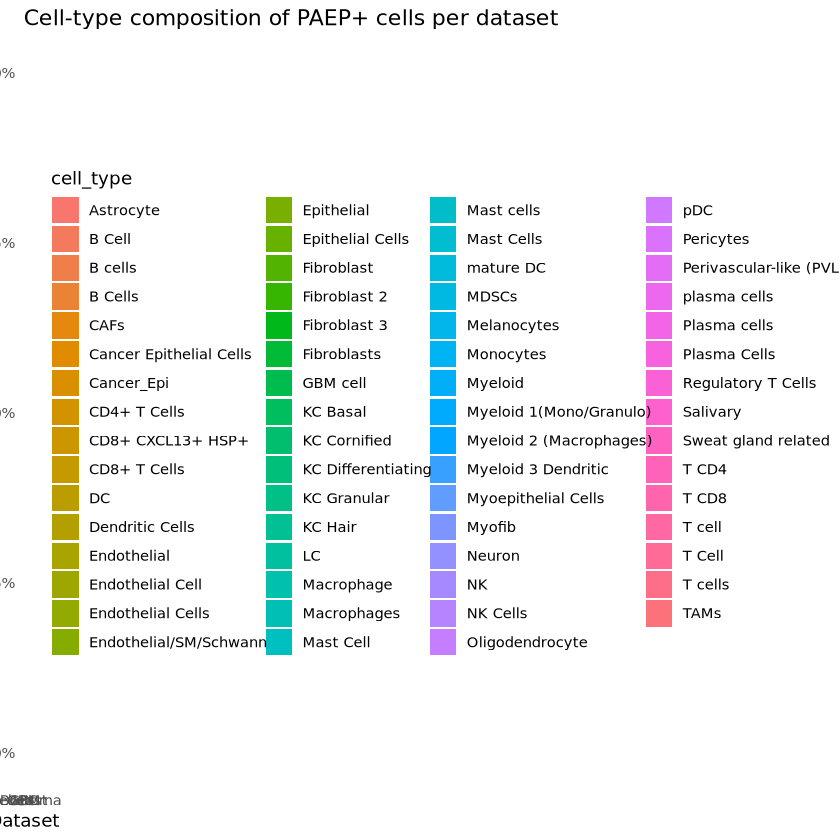

In [31]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(forcats)

# List your objects here
objs <- list(
  Breast = breast,
  GBM = GBM,
  HN = HN,
  CRC = CRC,
  Melanoma = Melanoma
)

# Which metadata column to treat as cell type label?
# Change if different in some objects (e.g. "predicted.id" or "cell_types_full")
cell_type_col <- "predicted.id"

# Gene of interest
gene <- "PAEP"

# Helper to find exact gene name in object (case-insensitive)
find_gene <- function(obj, g) {
  vars <- rownames(obj)
  # try exact first
  if (g %in% vars) return(g)
  # try case-insensitive match
  m <- vars[tolower(vars) == tolower(g)]
  if (length(m) >= 1) return(m[1])
  return(NA_character_)
}

# Collect per-cell info from each object
all_cells <- lapply(names(objs), function(ds) {
  obj <- objs[[ds]]
  if (is.null(obj) || !inherits(obj, "Seurat")) stop(paste(ds, "not found or not Seurat"))
  # find gene in this object
  g_found <- find_gene(obj, gene)
  if (is.na(g_found)) {
    warning(paste0("Gene ", gene, " not found in ", ds, " — filling NA for expression"))
    expr_vec <- rep(NA_real_, ncol(obj))
  } else {
    # use FetchData to be safe (uses active assay/data slot)
    expr_vec <- FetchData(obj, vars = g_found)[,1]
  }
  # cell type column fallback
  if (!(cell_type_col %in% colnames(obj@meta.data))) {
    # fallback: try other common names
    fallback <- c("cell_type", "cell_types_full", "celltype", "predicted.id", "annotation")
    found_fb <- intersect(fallback, colnames(obj@meta.data))
    if (length(found_fb) >= 1) {
      ct_col <- found_fb[1]
    } else {
      ct_col <- NA_character_
    }
  } else {
    ct_col <- cell_type_col
  }
  md <- obj@meta.data
  tibble::tibble(
    dataset = ds,
    cell = colnames(obj),
    cell_type = if (!is.na(ct_col)) as.character(md[[ct_col]]) else NA_character_,
    paep_expr = expr_vec
  )
})
cells_df <- bind_rows(all_cells)

# Define PAEP+ as expression > 0 (adjust threshold if needed)
cells_df <- cells_df %>%
  mutate(PAEP_pos = ifelse(is.na(paep_expr), NA, paep_expr > 0))

# Per-dataset summary
dataset_summary <- cells_df %>%
  group_by(dataset) %>%
  summarise(
    n_cells = n(),
    n_paep_pos = sum(PAEP_pos, na.rm = TRUE),
    pct_paep_pos = 100 * n_paep_pos / n_cells,
    mean_expr = mean(paep_expr, na.rm = TRUE),
    median_expr = median(paep_expr, na.rm = TRUE)
  ) %>%
  arrange(desc(pct_paep_pos))

print(dataset_summary)

# Per-dataset x celltype summary (only for cells with a defined cell_type)
celltype_summary <- cells_df %>%
  filter(!is.na(cell_type)) %>%
  group_by(dataset, cell_type) %>%
  summarise(
    n_cells = n(),
    n_paep_pos = sum(PAEP_pos, na.rm = TRUE),
    pct_within_type = 100 * n_paep_pos / n_cells,
    .groups = "drop"
  ) %>%
  arrange(dataset, desc(n_paep_pos))

# Also compute contribution to all PAEP+ cells (global)
total_paep_pos <- sum(cells_df$PAEP_pos, na.rm = TRUE)
celltype_summary <- celltype_summary %>%
  mutate(pct_of_all_paep_pos = 100 * n_paep_pos / total_paep_pos)

print(celltype_summary)

# ---- PLOTS ----

# Violin plot: distribution of PAEP expression per dataset
p1 <- cells_df %>%
  ggplot(aes(x = fct_reorder(dataset, paep_expr, .fun = median, .desc = TRUE), y = paep_expr)) +
  geom_violin(trim = TRUE) +
  geom_boxplot(width = 0.1, outlier.size = 0.5) +
  theme_minimal() +
  labs(x = "Dataset", y = paste0(gene, " expression (raw)"), title = paste0(gene, " expression by dataset"))

# Bar: % PAEP+ per dataset
p2 <- dataset_summary %>%
  ggplot(aes(x = fct_reorder(dataset, pct_paep_pos, .desc = TRUE), y = pct_paep_pos, fill = dataset)) +
  geom_col(show.legend = FALSE) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  theme_minimal() +
  labs(x = "Dataset", y = "% PAEP+ cells", title = paste0("% PAEP+ cells per dataset"))

# Bar: per-dataset top cell types by PAEP+ counts (top 10 per dataset)
top_celltypes_plot_df <- celltype_summary %>%
  group_by(dataset) %>%
  slice_max(order_by = n_paep_pos, n = 10, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(cell_type = paste0(dataset, " | ", cell_type)) %>%
  arrange(desc(n_paep_pos))

p3 <- top_celltypes_plot_df %>%
  ggplot(aes(x = fct_reorder(cell_type, n_paep_pos), y = n_paep_pos, fill = dataset)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  theme_minimal() +
  labs(x = "", y = "PAEP+ cells (count)", title = "Top cell types by PAEP+ counts (per dataset)")

# Combined display
print(p1)
print(p2)
print(p3)

# ---- OPTIONAL: stacked bar of contribution of cell types to all PAEP+ cells ----
stack_df <- celltype_summary %>%
  group_by(dataset, cell_type) %>%
  summarise(n_paep_pos = sum(n_paep_pos), .groups = "drop") %>%
  arrange(dataset, desc(n_paep_pos)) %>%
  group_by(dataset) %>%
  mutate(frac = n_paep_pos / sum(n_paep_pos))

ggplot(stack_df, aes(x = dataset, y = frac, fill = cell_type)) +
  geom_col() +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal() +
  labs(x = "Dataset", y = "Fraction of dataset PAEP+ cells", title = "Cell-type composition of PAEP+ cells per dataset")

# Save summaries to csv if needed
#write.csv(dataset_summary, "PAEP_dataset_summary.csv", row.names = FALSE)
#write.csv(celltype_summary, "PAEP_celltype_summary.csv", row.names = FALSE)


In [69]:
pdf("PAEP_celltypes_across_cancers.pdf",height=12, width=8)
p3
dev.off()

pdf 
  2

In [21]:
# Function to safely get gene expression from any assay
get_gene_vector <- function(obj, gene="PAEP", assay=NULL, slot="data") {
  if (is.null(assay)) assay <- DefaultAssay(obj)  # use active assay if not specified
  if (!assay %in% names(obj@assays)) stop(paste("Assay", assay, "not found in object"))
  
  expr_mat <- slot(obj[[assay]], slot)
  if (!gene %in% rownames(expr_mat)) {
    warning(paste("Gene", gene, "not found in", assay, slot, "- returning zeros"))
    return(rep(0, ncol(obj)))
  }
  
  return(expr_mat[gene, ])
}

# Example for one object
DefaultAssay(breast) <- "SCT"   # set active assay
PAEP_expr <- get_gene_vector(breast, gene="PAEP", assay="SCT", slot="data")

# Add to metadata
breast$PAEP_pos <- PAEP_expr > 0


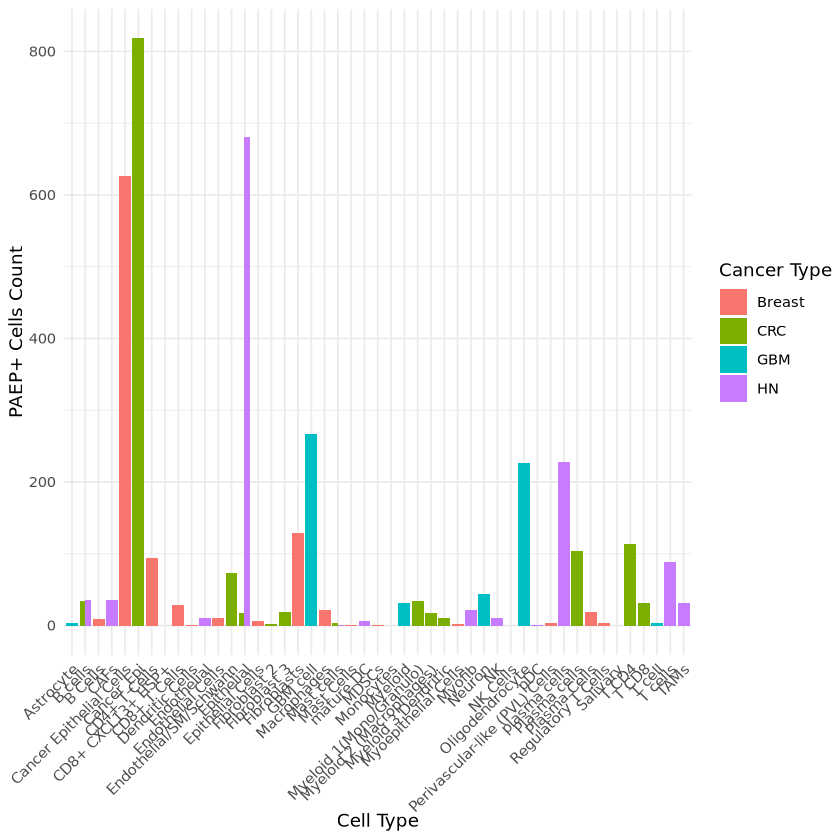

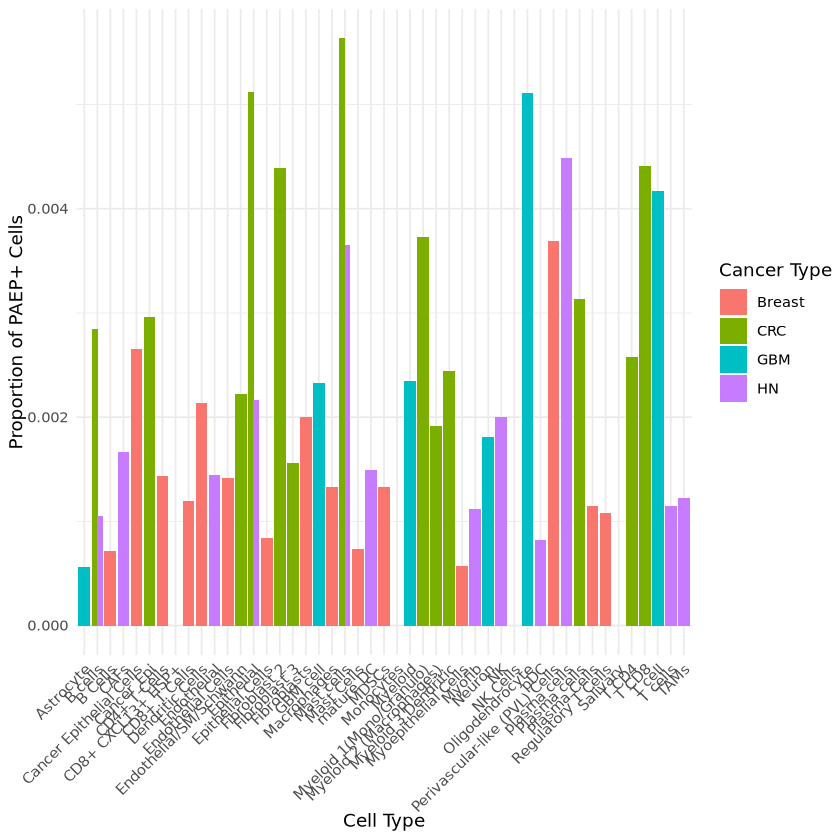

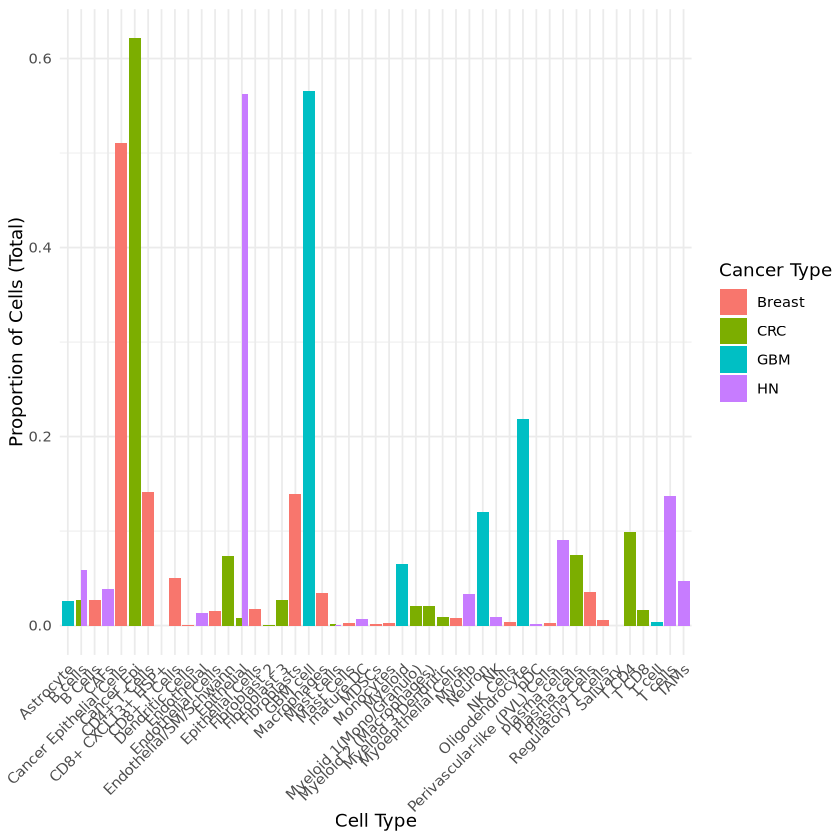

In [33]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(purrr)

# List of your Seurat objects
objs <- list(
  Breast = breast,
  GBM = GBM,
  HN = HN,
  CRC = CRC
#  Melanoma = Melanoma
)

# Function to safely extract gene expression
get_gene_vector <- function(obj, gene="PAEP", assay=NULL, slot="data") {
  if (is.null(assay)) assay <- DefaultAssay(obj)
  if (!assay %in% names(obj@assays)) stop(paste("Assay", assay, "not found in object"))
  
  expr_mat <- slot(obj[[assay]], slot)
  if (!gene %in% rownames(expr_mat)) {
    warning(paste("Gene", gene, "not found in", assay, slot, "- returning zeros"))
    return(rep(0, ncol(obj)))
  }
  return(expr_mat[gene, ])
}

# Process each object
all_paep <- map_dfr(names(objs), function(name) {
  obj <- objs[[name]]
  
  # Set active assay (SCT in your case)
  DefaultAssay(obj) <- "SCT"
  
  # Extract normalized expression
  PAEP_expr <- get_gene_vector(obj, gene="PAEP", assay="SCT", slot="data")
  
  # K-means clustering on spatial coordinates if available, else skip
  if ("spatial" %in% names(obj@images)) {
    coords <- obj@images[[1]]@coordinates[, 1:2]
    km <- kmeans(coords, centers=5, nstart=20)
    tissue_cluster <- as.character(km$cluster)
  } else {
    tissue_cluster <- rep("All", ncol(obj))
  }
  
  # Create dataframe per cell
  df <- data.frame(
    sample = obj$orig.ident,
    cell_type = obj$predicted.id,
    tissue = tissue_cluster,
    PAEP_pos = PAEP_expr > 0,
    stringsAsFactors = FALSE
  )
  df$cancer_type <- name
  return(df)
})

# Summarize counts and proportions per sample, tissue, and cell_type
summary_df <- all_paep %>%
  group_by(cancer_type, sample, tissue, cell_type) %>%
  summarise(
    n_cells = n(),
    n_PAEP_pos = sum(PAEP_pos),
    prop_PAEP = n_PAEP_pos / n_cells,
    .groups = "drop"
  )

# Also compute proportion relative to total cells per cancer type
total_cells <- all_paep %>%
  group_by(cancer_type) %>%
  summarise(total = n())

summary_df <- summary_df %>%
  left_join(total_cells, by="cancer_type") %>%
  mutate(prop_total = n_cells / total)

# --- Plot counts ---
ggplot(summary_df, aes(x=cell_type, y=n_PAEP_pos, fill=cancer_type)) +
  geom_bar(stat="identity", position=position_dodge(width=0.8)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle=45, hjust=1)) +
  labs(y="PAEP+ Cells Count", x="Cell Type", fill="Cancer Type")

# --- Plot proportion per cell type ---
ggplot(summary_df, aes(x=cell_type, y=prop_PAEP, fill=cancer_type)) +
  geom_bar(stat="identity", position=position_dodge(width=0.8)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle=45, hjust=1)) +
  labs(y="Proportion of PAEP+ Cells", x="Cell Type", fill="Cancer Type")

# --- Plot proportion relative to total cells ---
ggplot(summary_df, aes(x=cell_type, y=prop_total, fill=cancer_type)) +
  geom_bar(stat="identity", position=position_dodge(width=0.8)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle=45, hjust=1)) +
  labs(y="Proportion of Cells (Total)", x="Cell Type", fill="Cancer Type")


In [25]:
# List all available assays for each object
map(objs, ~ Assays(.x))


$Breast
[1] "Xenium"          "ControlCodeword" "ControlProbe"    "SCT"            

$GBM
[1] "Xenium"          "ControlCodeword" "ControlProbe"    "SCT"            

$HN
[1] "Xenium"          "ControlCodeword" "ControlProbe"    "SCT"            

$CRC
[1] "Xenium"          "ControlCodeword" "ControlProbe"   

$Melanoma
[1] "Xenium"          "ControlCodeword" "ControlProbe"

In [36]:
head(objs$HN)

,orig.ident,nCount_Xenium,nFeature_Xenium,nCount_ControlCodeword,nFeature_ControlCodeword,nCount_ControlProbe,nFeature_ControlProbe,nCount_SCT,nFeature_SCT,SCT_snn_res.1,⋯,prediction.score.Endothelial,prediction.score.T.cells,prediction.score.Myofib,prediction.score.Salivary,prediction.score.NK,prediction.score.plasma.cells,prediction.score.pDC,prediction.score.mature.DC,prediction.score.Mast.cells,prediction.score.max
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
aaaaefik-1,SeuratProject,148,58,0,0,0,0,177,58,0,⋯,0.000000000,0.00000000,0.000000000,0.02838155,0.00000000,0,0,0,0.000000000,0.9716185
aaaagogo-1,SeuratProject,214,76,0,0,0,0,207,76,16,⋯,0.000000000,0.12434948,0.000000000,0.00000000,0.00481338,0,0,0,0.000000000,0.8708371
aaaahbem-1,SeuratProject,154,61,0,0,0,0,182,61,1,⋯,0.000000000,0.00000000,0.000000000,0.07815019,0.00000000,0,0,0,0.000000000,0.9218498
aaaainfi-1,SeuratProject,239,94,0,0,0,0,221,94,7,⋯,0.000000000,0.04248465,0.000000000,0.00000000,0.00000000,0,0,0,0.000000000,0.9575154
aaaajame-1,SeuratProject,61,31,0,0,0,0,153,33,0,⋯,0.000000000,0.00000000,0.000000000,0.04492993,0.00000000,0,0,0,0.000000000,0.9550701
aaaajpgh-1,SeuratProject,217,69,0,0,0,0,207,69,11,⋯,0.000000000,0.00000000,0.000000000,0.13533687,0.00000000,0,0,0,0.000000000,0.7489505
aaaakdkp-1,SeuratProject,115,50,0,0,0,0,190,50,11,⋯,0.007965452,0.00000000,0.002268666,0.24378554,0.00000000,0,0,0,0.006747431,0.6430558
aaaanbdc-1,SeuratProject,99,48,0,0,0,0,184,48,0,⋯,0.000000000,0.01039533,0.005819741,0.11068478,0.00000000,0,0,0,0.000000000,0.8731001
aaaaphkh-1,SeuratProject,135,63,0,0,0,0,172,63,0,⋯,0.000000000,0.01856180,0.000000000,0.09929746,0.00000000,0,0,0,0.000000000,0.8821407


In [ ]:
ImageDimPlot(Melanoma, group.by = "predicted.id", size = 0.1, axes=TRUE)


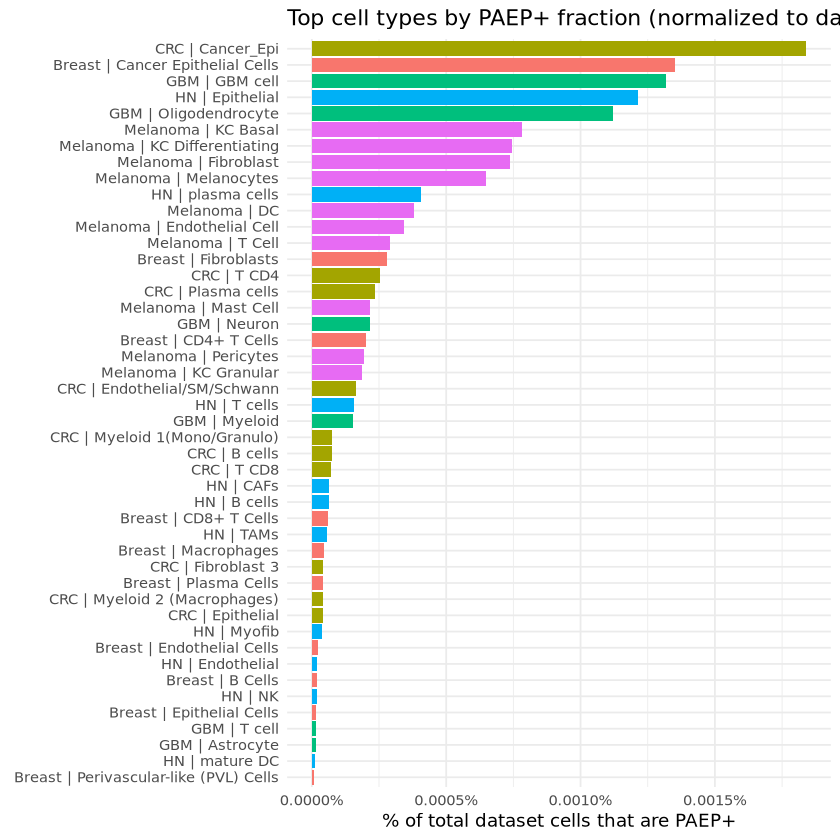

In [59]:
# Compute total cells per dataset
dataset_totals <- cells_df %>%
  group_by(dataset) %>%
  summarise(total_cells = n(), .groups = "drop")

# Per-dataset x celltype summary normalized by total dataset cells
celltype_summary_norm <- cells_df %>%
  filter(!is.na(cell_type)) %>%
  group_by(dataset, cell_type) %>%
  summarise(
    n_cells = n(),
    n_paep_pos = sum(PAEP_pos, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  left_join(dataset_totals, by = "dataset") %>%
  mutate(frac_paep_pos = n_paep_pos / total_cells)  # normalize by total dataset cells

# Top cell types per dataset by normalized fraction
top_celltypes_plot_df_norm <- celltype_summary_norm %>%
  group_by(dataset) %>%
  slice_max(order_by = frac_paep_pos, n = 10, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(cell_type = paste0(dataset, " | ", cell_type)) %>%
  arrange(desc(frac_paep_pos))

# Plot
p3_norm <- top_celltypes_plot_df_norm %>%
  ggplot(aes(x = fct_reorder(cell_type, frac_paep_pos), y = frac_paep_pos, fill = dataset)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  theme_minimal() +
  labs(x = "", y = "% of total dataset cells that are PAEP+", 
       title = "Top cell types by PAEP+ fraction (normalized to dataset size)")
p3_norm

In [77]:
pdf("PAEP_across_cancers_Vln_nonzero.pdf",width=12, height=8)
cells_df_sub<-cells_df[cells_df$paep_expr > 0,]
cells_df_sub %>%
  ggplot(aes(x = fct_reorder(dataset, paep_expr, .fun = median, .desc = TRUE), y = paep_expr)) +
  geom_violin(trim = TRUE) +
  geom_boxplot(width = 0.1, outlier.size = 0.5) +
  theme_minimal() +
  labs(x = "Dataset", y = paste0(gene, " expression (raw)"), title = paste0(gene, " expression by dataset"))
dev.off()

pdf 
  2

Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”


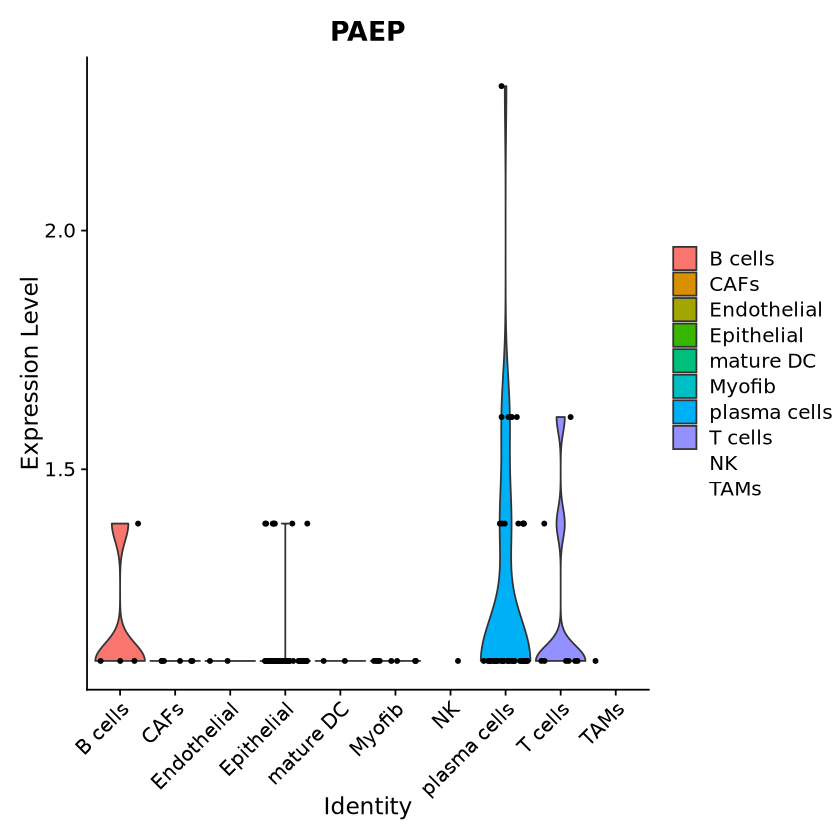

In [80]:
#pdf("PAEP_HN_Vln_nonzero.pdf",width=12, height=8)

VlnPlot(
  subset(HN, subset = PAEP > 1),
  features = "PAEP",
  group.by = "predicted.id")
#dev.off()